# Imports

In [100]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Activation, Reshape, Input, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras import backend
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import confusion_matrix
from percolation import read_percolation_data
from sklearn.model_selection import train_test_split
import sys

# Loading Data

In [141]:
L = 32
pc = 0.59274
#p_arr = np.round(np.arange(0, 1.0, 0.01), 4)
#p_arr = np.round(np.array([0.57, 0.58, 0.61, 0.62]), 4)
p_arr = np.round(np.array([0.2 , 0.9]), 4)
p_arr = np.append(p_arr, pc)

In [249]:
X, y = read_percolation_data(L, p_arr, pc, max_configs_per_p=10000)

In [250]:
print(X.shape, y.shape)

(30000, 32, 32, 1) (30000,)


In [251]:
N = X.shape[0]
L = X.shape[1] 

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [253]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print('X_train.shape:', X_train.shape, ', y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, ', y_test.shape:', y_test.shape)

X.shape: (30000, 32, 32, 1) , y.shape: (30000,)
X_train.shape: (24000, 32, 32, 1) , y_train.shape: (24000,)
X_test.shape: (6000, 32, 32, 1) , y_test.shape: (6000,)


In [254]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 2


# Defining and training the AutoEncoder

In [255]:
latent_space_dimension = 10

In [256]:
def custom_activation(x):
    return (backend.sigmoid(x) * 2) - 1

In [257]:
class AutoEncoder(Model):
  def __init__(self, L, latent_space_dimension):
    super(AutoEncoder, self).__init__()
    
    self.encoder = tf.keras.Sequential([
      Input(shape=(L, L, 1)), 
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      Flatten(),
      Dense(latent_space_dimension, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
      Input(shape=latent_space_dimension),
      Dense(int(L * L / 16), activation='relu'),
      Reshape((int(L / 4), int(L / 4), 1)),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(1, kernel_size=(3,3), activation=custom_activation, padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [262]:
class AutoEncoder(Model):
  def __init__(self, L, latent_space_dimension):
    super(AutoEncoder, self).__init__()
    
    self.encoder = tf.keras.Sequential([
      Input(shape=(L, L, 1)), 
      Flatten(),
      Dense(latent_space_dimension, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
      Input(shape=latent_space_dimension),
      Dense(L * L, activation='relu'),
      Reshape((L, L, 1))])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [263]:
autoencoder = AutoEncoder(L, latent_space_dimension)

In [264]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())#, metrics=[Accuracy()])

In [265]:
r = autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_test, X_test))

Epoch 1/20
750/750 [==============================] - 1s 909us/step - loss: 0.8075 - val_loss: 0.7857
Epoch 2/20
750/750 [==============================] - 1s 812us/step - loss: 0.7877 - val_loss: 0.7816
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.7852 - val_loss: 0.7802
Epoch 4/20
750/750 [==============================] - 1s 899us/step - loss: 0.7840 - val_loss: 0.7789
Epoch 5/20
750/750 [==============================] - 1s 919us/step - loss: 0.7831 - val_loss: 0.7786
Epoch 6/20
750/750 [==============================] - 1s 778us/step - loss: 0.7829 - val_loss: 0.7784
Epoch 7/20
750/750 [==============================] - 1s 871us/step - loss: 0.7822 - val_loss: 0.7778
Epoch 8/20
750/750 [==============================] - 1s 838us/step - loss: 0.7817 - val_loss: 0.7774
Epoch 9/20
750/750 [==============================] - 1s 842us/step - loss: 0.7813 - val_loss: 0.7772
Epoch 10/20
750/750 [==============================] - 1s 908us/step - loss: 0.7811 

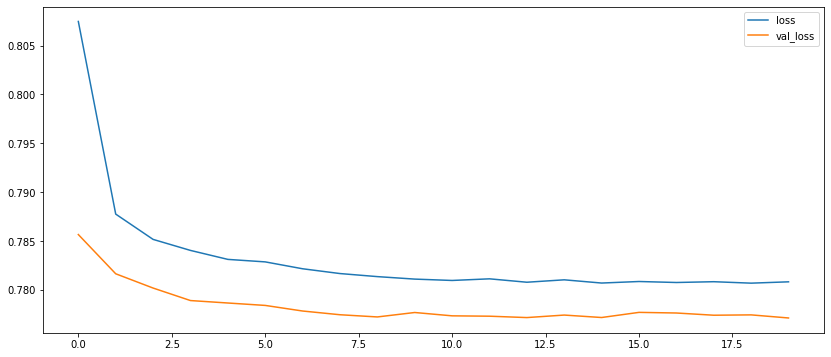

In [266]:
plt.figure(figsize=(14,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [155]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [47]:
encoded_imgs = autoencoder.encoder([X[0], X[-1]]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

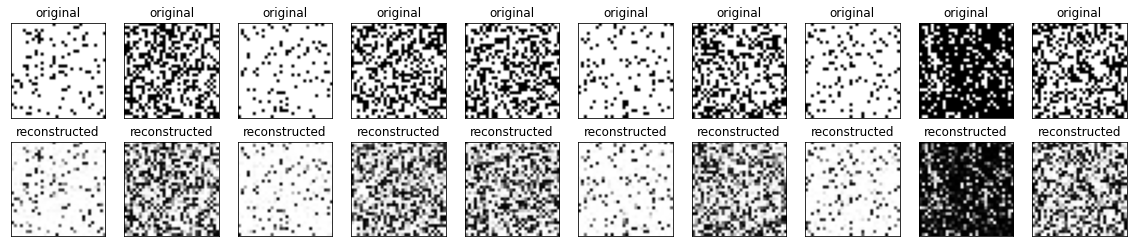

In [156]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()